<a href="https://colab.research.google.com/github/Wooshaw/ESE_527_Project/blob/main/Stock_Price_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Price Prediction Model**

We plan to build a long-short-term memory (LSTM) network to predict the day price direction of stocks. We will compare our model with 4 selected machine learning-based benchmarks, including 1. logistic regression, 2. decision tree, 3. random forest, and 4. Gradient boosting ensemble, on 5 to 10 stocks from Yahoo Finance.

In [ ]:
# pip install yfinance

import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime as dt
import copy
from collections import Counter
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Getting the Data

In [ ]:
df_BRK = yf.Ticker("BRK-A").history(period="max")

df_BRK.reset_index(inplace=True) # Make date no longer an Index

df_BRK.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-03-17 00:00:00-05:00,290.0,310.0,290.0,290.0,10000,0.0,0.0
1,1980-03-18 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
2,1980-03-19 00:00:00-05:00,290.0,310.0,290.0,290.0,20000,0.0,0.0
3,1980-03-20 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
4,1980-03-21 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0


## Data Exploration & Visualization

In [ ]:
def analyze(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("The Shape of the dataset is", dataframe.shape, "\n")
    print("The columns of the dataset consists of", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")

In [ ]:
def plot(dataframe):
  """Draws a graph of price movements"""
  print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
  dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])

In [ ]:
analyze(df_BRK)

The Shape of the dataset is (10993, 8) 

The columns of the dataset consists of Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10993 entries, 0 to 10992
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          10993 non-null  datetime64[ns, America/New_York]
 1   Open          10993 non-null  float64                         
 2   High          10993 non-null  float64                         
 3   Low           10993 non-null  float64                         
 4   Close         10993 non-null  float64                         
 5   Volume        10993 non-null  int64                           
 6   Dividends     10993 non-null  float64                         
 7   Stock Splits  10993 non-null  float64                         
dtypes: dateti

The data ranges from 2015-11-10 00:00:00-05:00 to 2023-10-20 00:00:00-04:00


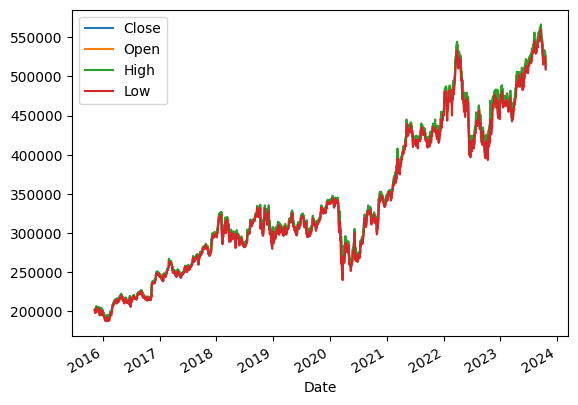

In [ ]:
plot(df_BRK.iloc[-2000:,:])

As noticeable, around March 2020, we see a sudden drop in the price, after which it reports steady growth until recently.

It will be challenging for a model in the stock prediction using machine learning project to correctly estimate the rapid changes that we can see in March 2020 and February 2022. We will focus on evaluating the model performance in predicting the more recent values after training it on the past data.

Similarly, plotting the Open and Close value of the stock for each day gives equivalent observations.

## Plot for Close, Open, High, and Low prices.

The data ranges from 2023-05-31 00:00:00-04:00 to 2023-10-20 00:00:00-04:00


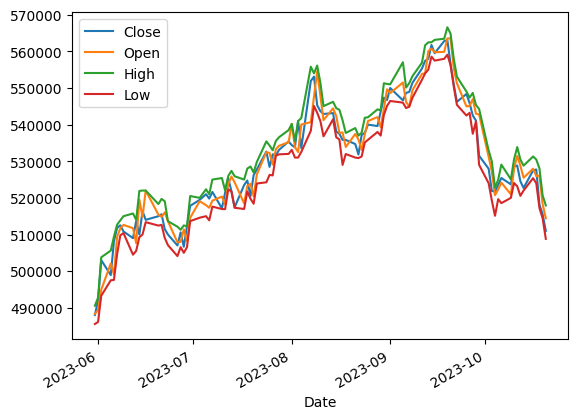

In [ ]:
plot(df_BRK.iloc[-100:,:])

## The volatility of 3 days, 7 days, 14 days window, which measures how much stock price moves

<Axes: xlabel='Date'>

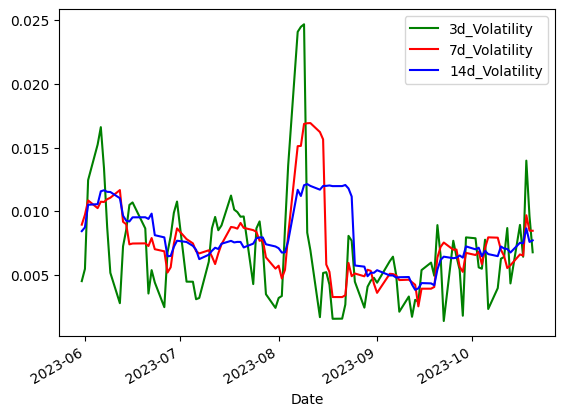

In [ ]:
volatility_frame = copy.deepcopy(df_BRK[['Date','Close']])
volatility_frame['Daily_Return'] = volatility_frame['Close'].pct_change()
volatility_frame['3d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=3).std()
volatility_frame['7d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=7).std()
volatility_frame['14d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=14).std()
volatility_frame.iloc[-100:,:].plot(x="Date", y=["3d_Volatility","7d_Volatility","14d_Volatility"],color=['green','red','blue'])

## The Lagged Scatter plot of 1 days, 3 days, 7 days window, which measures how the value of the stock price today relates to its value on the previous day(s)

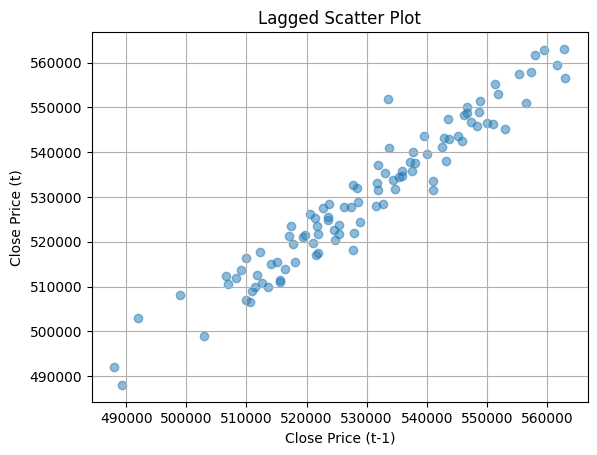

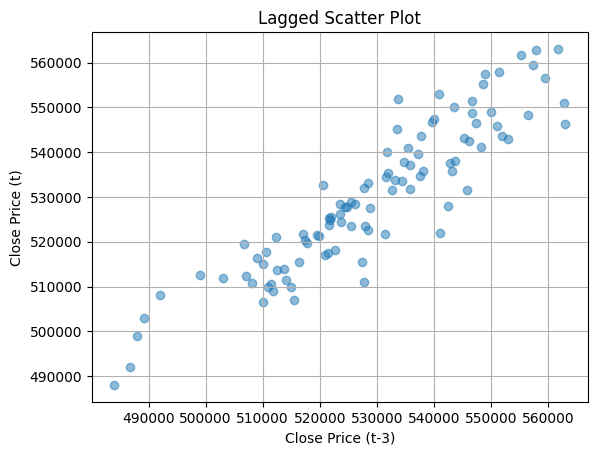

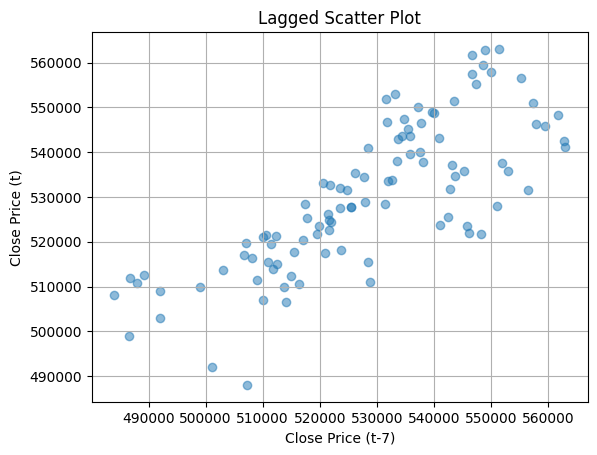

In [ ]:
lag_frame = copy.deepcopy(df_BRK[['Date','Close']])
lag_frame['1d_Lagged_Close'] = lag_frame['Close'].shift(1)
lag_frame['3d_Lagged_Close'] = lag_frame['Close'].shift(3)
lag_frame['7d_Lagged_Close'] = lag_frame['Close'].shift(7)


plt.scatter(lag_frame.iloc[-100:,:]['1d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{1})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

plt.scatter(lag_frame.iloc[-100:,:]['3d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{3})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

plt.scatter(lag_frame.iloc[-100:,:]['7d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{7})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

## The average plot of 3 days, 7 days, 14 days window, which smooth the stock price and show us the long-term trends.

<Axes: xlabel='Date'>

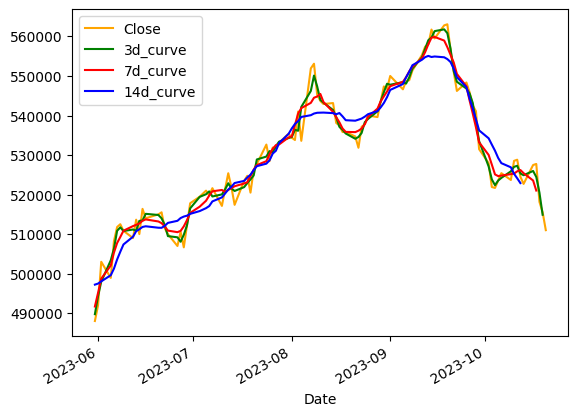

In [ ]:
close_frame = copy.deepcopy(df_BRK[['Date','Close']])
close_frame["3d_curve"] = close_frame['Close'].rolling(window=3, center=True).mean()
close_frame["7d_curve"] = close_frame['Close'].rolling(window=7, center=True).mean()
close_frame["14d_curve"] = close_frame['Close'].rolling(window=14, center=True).mean()
close_frame.iloc[-100:,:].plot(x="Date", y=["Close","3d_curve","7d_curve","14d_curve"],color=['orange','green','red','blue'])

# Data Preprocessing
## 1. Feature Selection
- Selecting the most relevant features for modeling to avoid overfitting and reduce computational complexity

In [ ]:
# Dropping 'Dividends' and 'Stock Splits' columns
df_BRK.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

df_BRK.tail()

,Date,Open,High,Low,Close,Volume
10988,2023-10-16 00:00:00-04:00,527957.0,531300.0,525380.0,527475.0,9100
10989,2023-10-17 00:00:00-04:00,525924.0,530475.0,524000.0,527750.0,7100
10990,2023-10-18 00:00:00-04:00,526116.0,528031.0,517200.0,518145.0,7600
10991,2023-10-19 00:00:00-04:00,518293.0,520675.0,514425.0,515550.0,7000
10992,2023-10-20 00:00:00-04:00,514438.0,517954.0,508815.0,511000.0,7800


## 2. Feature Engineering
- Create additional features that might be useful for modeling, such as moving averages, technical indicators (e.g., RSI, MACD), or price volatility measures.

Bring previous price into today's price

In [ ]:
featured_frame = copy.deepcopy(df_BRK)
featured_frame['1d_Close'] = featured_frame['Close'].shift(1)
featured_frame['3d_Close'] = featured_frame['Close'].shift(3)
featured_frame['7d_Close'] = featured_frame['Close'].shift(7)
featured_frame.tail()

,Date,Open,High,Low,Close,Volume,1d_Close,3d_Close,7d_Close
10988,2023-10-16 00:00:00-04:00,527957.0,531300.0,525380.0,527475.0,9100,522700.0,528820.0,523545.0
10989,2023-10-17 00:00:00-04:00,525924.0,530475.0,524000.0,527750.0,7100,527475.0,524517.0,525425.0
10990,2023-10-18 00:00:00-04:00,526116.0,528031.0,517200.0,518145.0,7600,527750.0,522700.0,523690.0
10991,2023-10-19 00:00:00-04:00,518293.0,520675.0,514425.0,515550.0,7000,518145.0,527475.0,528530.0
10992,2023-10-20 00:00:00-04:00,514438.0,517954.0,508815.0,511000.0,7800,515550.0,527750.0,528820.0


The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI oscillates between zero and 100 and is often used to identify overbought or oversold conditions in a traded security.

In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta.dropna()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = -down.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

featured_frame['RSI'] = compute_rsi(featured_frame['Close'])
featured_frame.tail()

,Date,Open,High,Low,Close,Volume,1d_Close,3d_Close,7d_Close,RSI
10988,2023-10-16 00:00:00-04:00,527957.0,531300.0,525380.0,527475.0,9100,522700.0,528820.0,523545.0,29.876381
10989,2023-10-17 00:00:00-04:00,525924.0,530475.0,524000.0,527750.0,7100,527475.0,524517.0,525425.0,32.695693
10990,2023-10-18 00:00:00-04:00,526116.0,528031.0,517200.0,518145.0,7600,527750.0,522700.0,523690.0,27.410468
10991,2023-10-19 00:00:00-04:00,518293.0,520675.0,514425.0,515550.0,7000,518145.0,527475.0,528530.0,31.813095
10992,2023-10-20 00:00:00-04:00,514438.0,517954.0,508815.0,511000.0,7800,515550.0,527750.0,528820.0,31.079875


Bollinger Bands are a volatility indicator that consists of a middle band being an N-period simple moving average (SMA), an upper band at K times an N-period standard deviation above the middle band, and a lower band at K times an N-period standard deviation below the middle band.

In [2]:
featured_frame['Daily_Return'] = featured_frame['Close'].pct_change()
featured_frame['Upward_Movement'] = (featured_frame['Daily_Return'] > 0).astype(int)
featured_frame['No_Change'] = (featured_frame['Daily_Return'] == 0).astype(int)
featured_frame['SMA'] = featured_frame['Close'].rolling(window=14).mean()
featured_frame['STD'] = featured_frame['Close'].rolling(window=14).std()
featured_frame['Upper_BB'] = featured_frame['SMA'] + (featured_frame['STD'] * 2)
featured_frame['Lower_BB'] = featured_frame['SMA'] - (featured_frame['STD'] * 2)
featured_frame.tail()

NameError: ignored

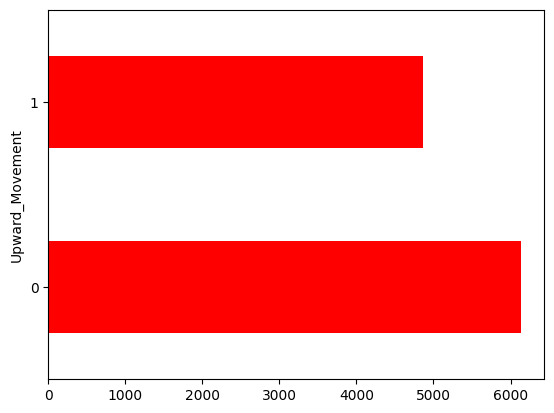

In [ ]:
fig = plt.figure()
plot = featured_frame.groupby(['Upward_Movement']).size().plot(kind='barh', color='red')
plt.show()

<ipython-input-52-6d147a942565>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = featured_frame.corr()


<Axes: title={'center': 'Correlation Matrix'}>

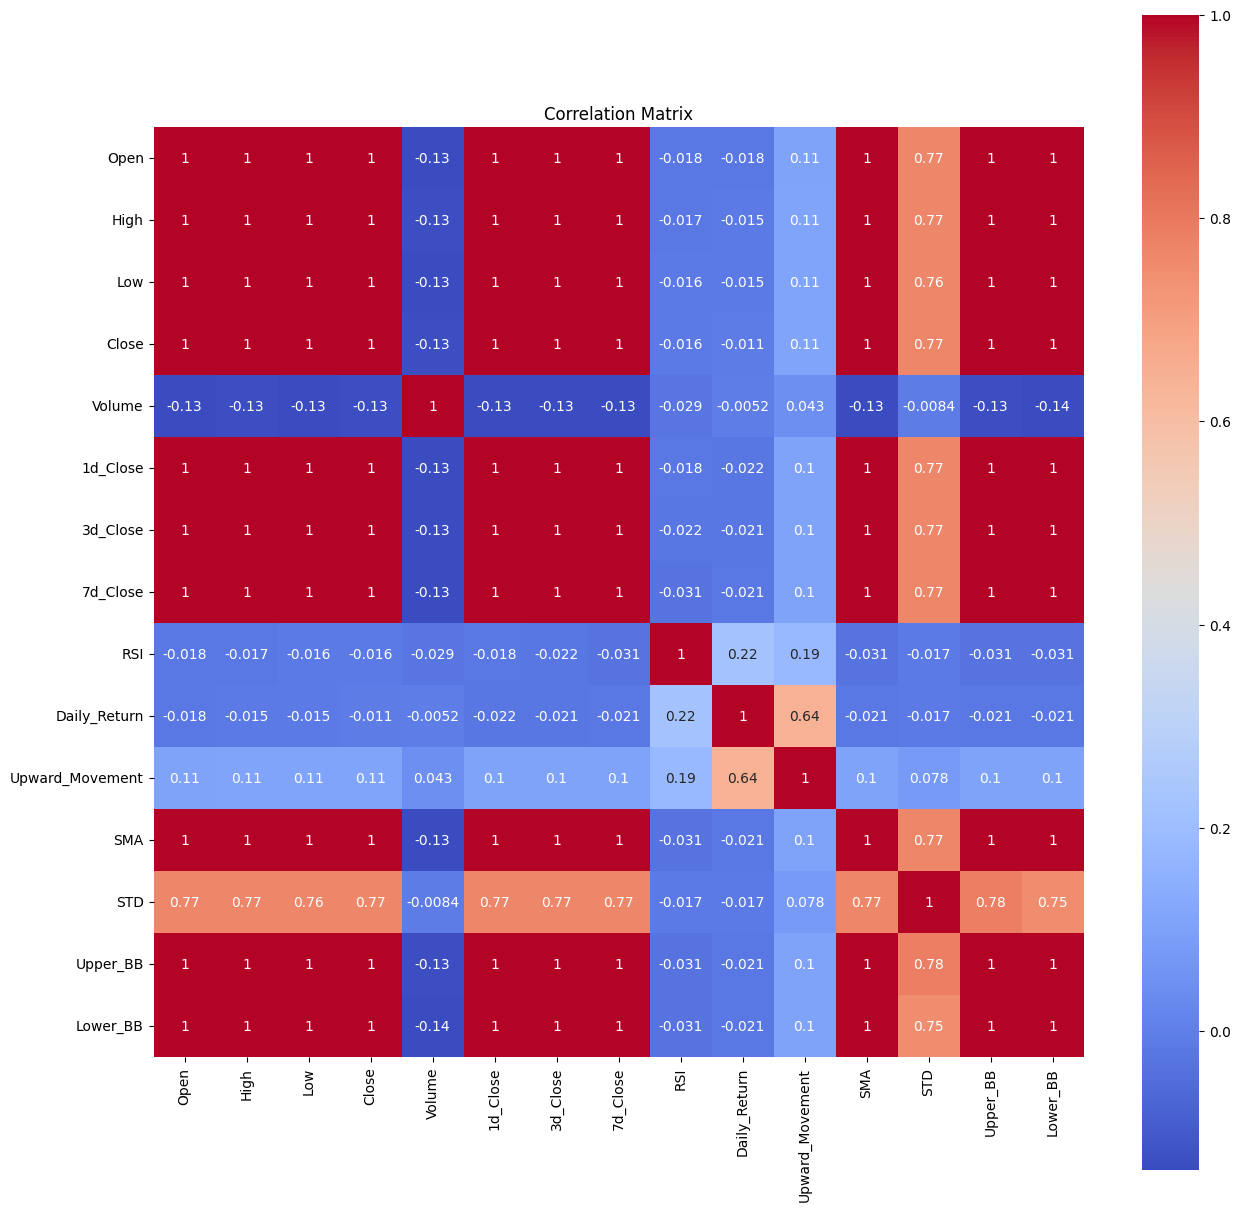

In [ ]:
# correlation
correlation = featured_frame.corr()
plt.figure(figsize=(15,15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm')

# Outliers detection

Plot of stock price movements with bollinger bands and the corresponding movement of RSI

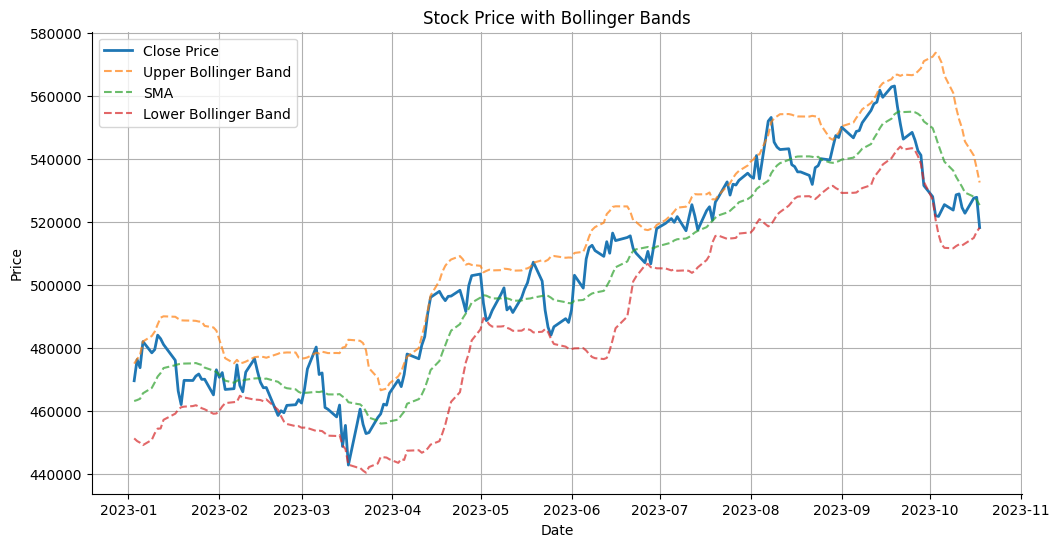

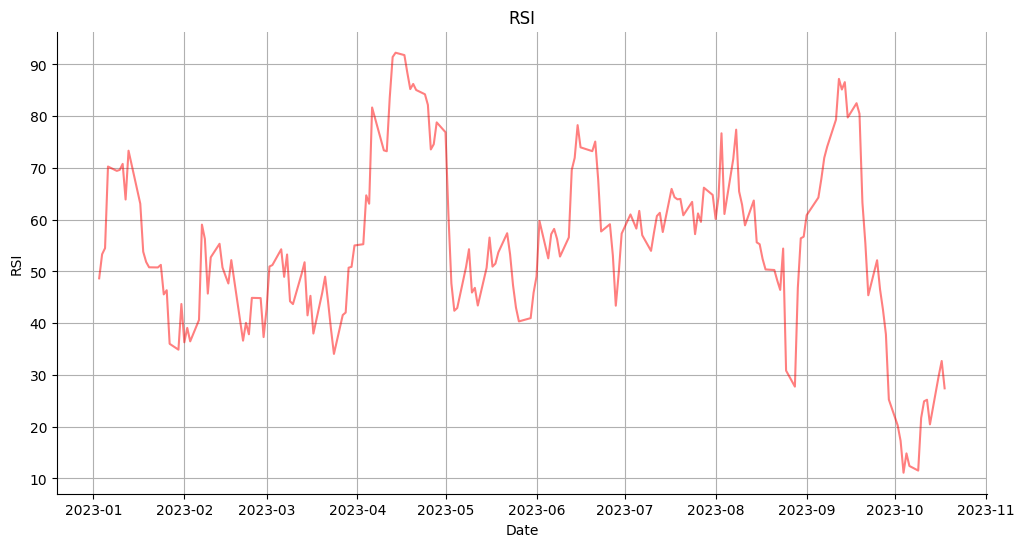

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for the desired timeframe (from 2020 to the current date)
start_date = '2023-01-01'
end_date = '2023-10-18'  # Replace with the current date

filtered_frame = featured_frame[(featured_frame['Date'] >= start_date) & (featured_frame['Date'] <= end_date)]

# Create a plot for the stock price and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(filtered_frame['Date'], filtered_frame['Close'], label='Close Price', linewidth=2)
plt.plot(filtered_frame['Date'], filtered_frame['Upper_BB'], label='Upper Bollinger Band', linestyle='--', alpha=0.7)
plt.plot(filtered_frame['Date'], filtered_frame['SMA'], label='SMA', linestyle='--', alpha=0.7)
plt.plot(filtered_frame['Date'], filtered_frame['Lower_BB'], label='Lower Bollinger Band', linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Bollinger Bands')
plt.legend(loc='upper left')
plt.grid(True)
sns.despine()

# Create a separate plot for RSI
plt.figure(figsize=(12, 6))
plt.plot(filtered_frame['Date'], filtered_frame['RSI'], label='RSI', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI')
plt.grid(True)
sns.despine()
plt.show()

## The moving average and the moving standard deviation

Calculate the moving average and the moving standard deviation for a window (e.g., 50 or 200 days). Any data point outside a certain number of standard deviations (e.g., 2 or 3) from the moving average can be considered an outlier.

{False: 358, True: 7}


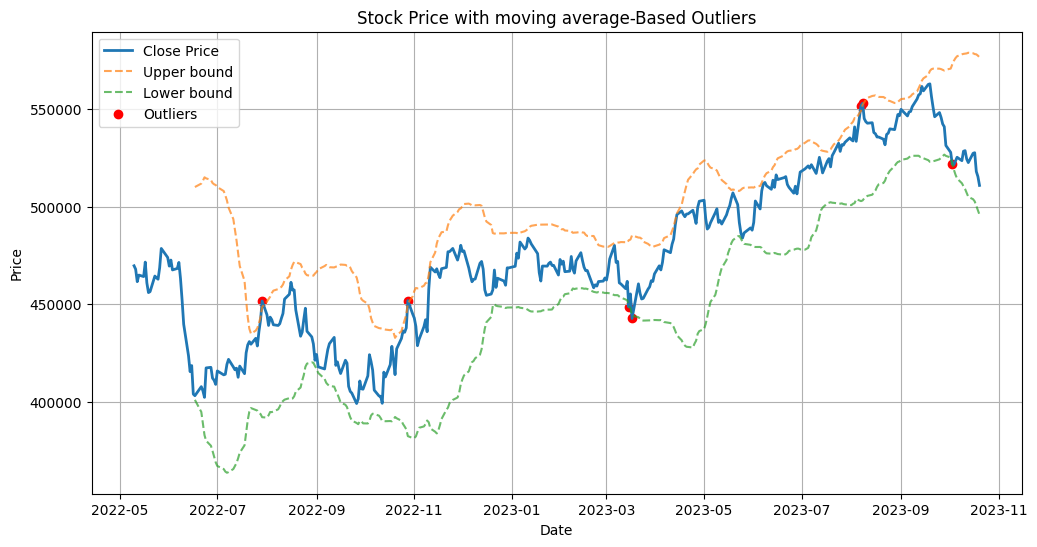

,Date,Open,High,Low,Close,Volume,1d_Close,3d_Close,7d_Close,RSI,...,Upward_Movement,SMA,STD,Upper_BB,Lower_BB,moving_avg,moving_std,lower_bound,upper_bound,outlier
10988,2023-10-16 00:00:00-04:00,527957.0,531300.0,525380.0,527475.0,9100,522700.0,528820.0,523545.0,29.876381,...,1,527952.357143,6548.009393,541048.375930,514856.338356,541339.821429,14973.593470,503905.837753,578773.805104,False
10989,2023-10-17 00:00:00-04:00,525924.0,530475.0,524000.0,527750.0,7100,527475.0,524517.0,525425.0,32.695693,...,1,526899.142857,5041.492405,536982.127667,516816.158047,540583.392857,15110.311437,502807.614264,578359.171450,False
10990,2023-10-18 00:00:00-04:00,526116.0,528031.0,517200.0,518145.0,7600,527750.0,522700.0,523690.0,27.410468,...,0,525259.142857,3590.485651,532440.114159,518078.171555,539395.535714,15529.597764,500571.541305,578219.530124,False
10991,2023-10-19 00:00:00-04:00,518293.0,520675.0,514425.0,515550.0,7000,518145.0,527475.0,528530.0,31.813095,...,0,524121.500000,3971.795791,532065.091583,516177.908417,537975.571429,15835.335369,498387.233006,577563.909851,False
10992,2023-10-20 00:00:00-04:00,514438.0,517954.0,508815.0,511000.0,7800,515550.0,527750.0,528820.0,31.079875,...,0,522910.071429,5128.884681,533167.840791,512652.302066,536317.892857,16151.265022,495939.730303,576696.055412,False


In [ ]:
outlier_moving_averages = copy.deepcopy(featured_frame)[-365:]

window_size = 28
outlier_moving_averages['moving_avg'] = outlier_moving_averages['Close'].rolling(window=window_size).mean()
outlier_moving_averages['moving_std'] = outlier_moving_averages['Close'].rolling(window=window_size).std()

# Define a threshold for outliers (e.g., 2 standard deviations from the moving average)
threshold = 2.5
outlier_moving_averages['lower_bound'] = outlier_moving_averages['moving_avg'] - threshold * outlier_moving_averages['moving_std']
outlier_moving_averages['upper_bound'] = outlier_moving_averages['moving_avg'] + threshold * outlier_moving_averages['moving_std']

# Identify the outliers
outlier_moving_averages['outlier'] = (outlier_moving_averages['Close'] < outlier_moving_averages['lower_bound']) | (outlier_moving_averages['Close'] > outlier_moving_averages['upper_bound'])

print(dict(Counter(outlier_moving_averages['outlier']).items()))

outliers = outlier_moving_averages[outlier_moving_averages['outlier']==True]
plt.figure(figsize=(12, 6))
plt.plot(outlier_moving_averages['Date'], outlier_moving_averages['Close'], label='Close Price', linewidth=2)
plt.plot(outlier_moving_averages['Date'], outlier_moving_averages['upper_bound'], label='Upper bound', linestyle='--', alpha=0.7)
plt.plot(outlier_moving_averages['Date'], outlier_moving_averages['lower_bound'], label='Lower bound', linestyle='--', alpha=0.7)
plt.scatter(outliers['Date'], outliers['Close'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with moving average-Based Outliers')
plt.legend()
plt.grid(True)
plt.show()

outlier_moving_averages.tail()

Time Series Decomposition: Decompose the time series into its trend, seasonal, and residual components using methods like the STL (Seasonal and Trend decomposition using LOESS) or ETS (Error, Trend, Seasonality). Outliers can often be easily detected in the residual component after the trend and seasonality have been accounted for.

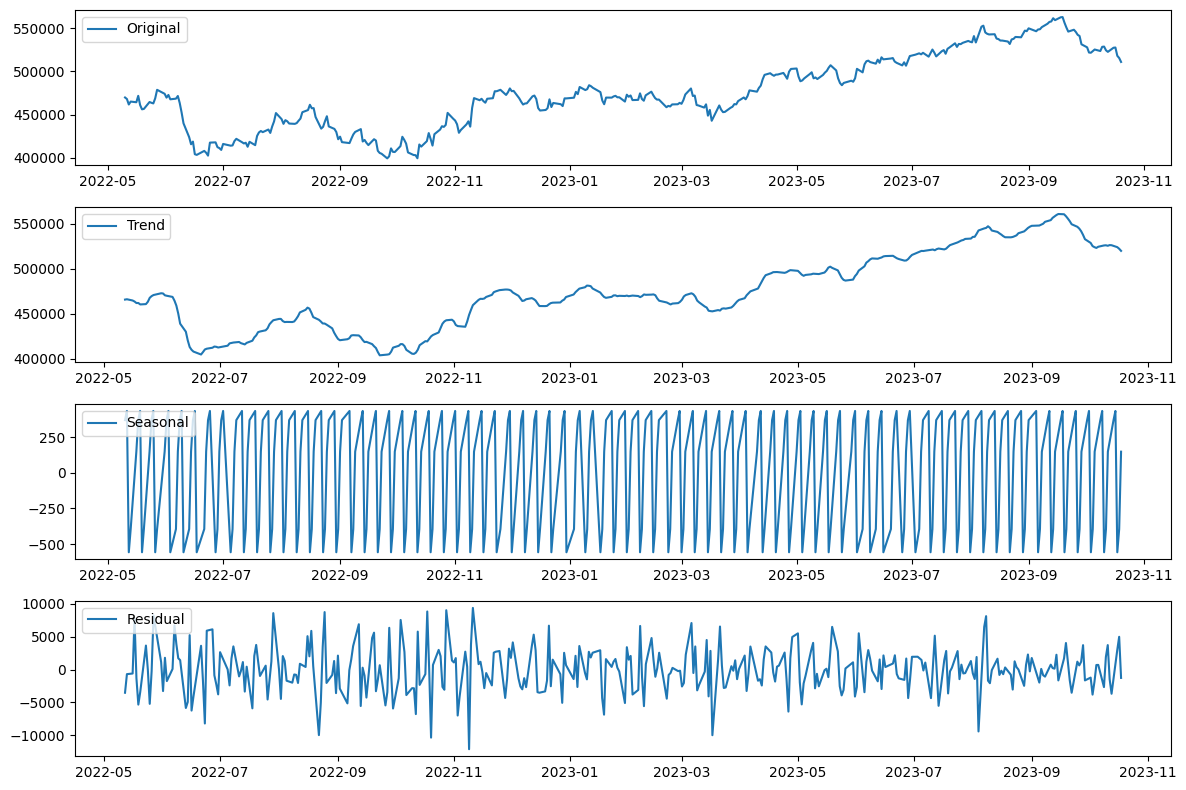

{False: 347, True: 18}


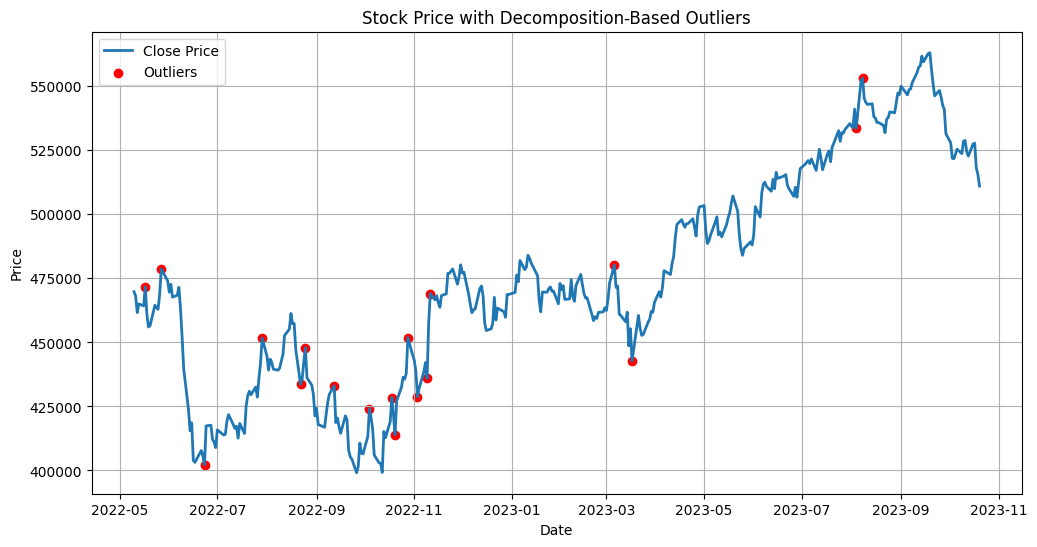

,Date,Open,High,Low,Close,Volume,1d_Close,3d_Close,7d_Close,RSI,Daily_Return,Upward_Movement,SMA,STD,Upper_BB,Lower_BB,outlier
360,2023-10-16,527957.0,531300.0,525380.0,527475.0,9100,522700.0,528820.0,523545.0,29.876381,0.009135,1,527952.357143,6548.009393,541048.375930,514856.338356,False
361,2023-10-17,525924.0,530475.0,524000.0,527750.0,7100,527475.0,524517.0,525425.0,32.695693,0.000521,1,526899.142857,5041.492405,536982.127667,516816.158047,False
362,2023-10-18,526116.0,528031.0,517200.0,518145.0,7600,527750.0,522700.0,523690.0,27.410468,-0.018200,0,525259.142857,3590.485651,532440.114159,518078.171555,False
363,2023-10-19,518293.0,520675.0,514425.0,515550.0,7000,518145.0,527475.0,528530.0,31.813095,-0.005008,0,524121.500000,3971.795791,532065.091583,516177.908417,False
364,2023-10-20,514438.0,517954.0,508815.0,511000.0,7800,515550.0,527750.0,528820.0,31.079875,-0.008826,0,522910.071429,5128.884681,533167.840791,512652.302066,False


In [ ]:
TSD_frame = copy.deepcopy(featured_frame)[-365:]
TSD_frame['Date'] = TSD_frame['Date'].dt.date
TSD_frame.set_index('Date', inplace=True)

# Decompose the time series into trend, seasonal, and residual components
decomposition = sm.tsa.seasonal_decompose(TSD_frame['Close'], model='additive', period=5)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(TSD_frame['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Identify outliers in the residuals
threshold = 2
residual_std = residual.std()
TSD_frame["outlier"] = (residual > threshold * residual_std) | (residual < -threshold * residual_std)
print(dict(Counter(TSD_frame['outlier']).items()))

TSD_frame.reset_index(inplace=True)
outliers = TSD_frame[TSD_frame['outlier']==True]
plt.figure(figsize=(12, 6))
plt.plot(TSD_frame['Date'], TSD_frame['Close'], label='Close Price', linewidth=2)
plt.scatter(outliers['Date'], outliers['Close'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Decomposition-Based Outliers')
plt.legend()
plt.grid(True)
plt.show()

TSD_frame.tail()

Volatility-Based Thresholds sets a threshold for daily price volatility, and flag days with price movements that exceed this threshold as potential outliers.

Outliers:
                           Date      Open      High       Low     Close  \
10675 2022-07-19 00:00:00-04:00  421539.0  426598.0  417309.0  425110.0   
10736 2022-10-13 00:00:00-04:00  394152.0  417860.0  393012.0  415222.0   
10756 2022-11-10 00:00:00-05:00  448491.0  458385.0  444918.0  457665.0   
10860 2023-04-13 00:00:00-04:00  483904.0  500000.0  481321.0  490760.0   
10870 2023-04-27 00:00:00-04:00  497200.0  500000.0  492072.0  499700.0   
10895 2023-06-02 00:00:00-04:00  494932.0  503777.0  493283.0  503000.0   
10939 2023-08-07 00:00:00-04:00  540676.0  555800.0  538323.0  551920.0   

       Volume  1d_Close  3d_Close  7d_Close        RSI  Daily_Return  \
10675    2200  414450.0  412600.0  421800.0  62.638694      0.025721   
10736    2600  399251.0  403000.0  424180.0  56.729214      0.040002   
10756    3200  435945.0  438575.0  443004.0  66.850859      0.049823   
10860    5500  483500.0  476500.0  469760.0  91.441343      0.015016   
10870    4700  491500.0  4982

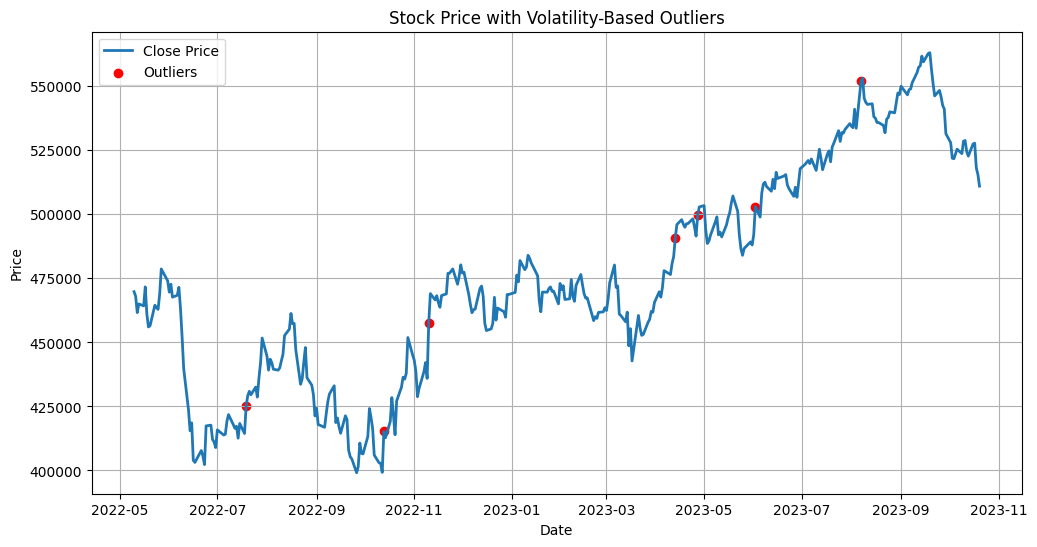

In [ ]:
Volatility_frame = copy.deepcopy(featured_frame)[-365:]
# Calculate daily returns
Volatility_frame['Returns'] = Volatility_frame['Close'].pct_change() * 100  # Percentage change in stock price

# Calculate historical volatility
window_size = 14  # Adjust the window size as needed
Volatility_frame['Volatility'] = Volatility_frame['Returns'].rolling(window=window_size).std()

# Set a threshold for identifying outliers
volatility_threshold = 2.0  # Adjust the threshold as needed

# Identify outliers based on the threshold
outliers = Volatility_frame[Volatility_frame['Returns'] > volatility_threshold * Volatility_frame['Volatility']]

# Print the outliers
print("Outliers:")
print(outliers)

plt.figure(figsize=(12, 6))
plt.plot(Volatility_frame['Date'], Volatility_frame['Close'], label='Close Price', linewidth=2)
plt.scatter(outliers['Date'], outliers['Close'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Volatility-Based Outliers')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Additional Feature Dropping
featured_frame = featured_frame.drop(['High', 'Low', 'Open', 'Upper_BB', 'Lower_BB'], axis=1)
featured_frame.describe()

,Close,Volume,1d_Close,3d_Close,7d_Close,RSI,Daily_Return,Upward_Movement,SMA,STD
count,10993.000000,1.099300e+04,10992.000000,10990.000000,10986.000000,10966.000000,10992.000000,10993.000000,10980.000000,10980.000000
mean,109762.433549,2.840257e+04,109725.930859,109651.841401,109500.390952,54.143255,0.000782,0.442190,109583.462653,1778.436277
std,127385.478807,5.670688e+04,127333.764927,127226.831541,127002.099781,20.057113,0.014324,0.496669,127002.558809,2570.839408
min,245.000000,0.000000e+00,245.000000,245.000000,245.000000,0.000000,-0.185090,0.000000,257.857143,0.000000
25%,8225.000000,2.100000e+03,8225.000000,8225.000000,8213.750000,41.285280,-0.005374,0.000000,8290.982143,123.325583
50%,71500.000000,1.600000e+04,71500.000000,71452.500000,71400.000000,53.661338,0.000000,0.000000,71646.607143,942.968629
75%,139400.000000,3.850000e+04,139325.000000,139200.000000,139000.000000,66.699508,0.006441,1.000000,138452.339286,2253.436915
max,563073.000000,2.740200e+06,563073.000000,563073.000000,563073.000000,100.000000,0.161290,1.000000,555073.142857,28246.068587


In [ ]:
featured_frame.sample(5)

,Date,Close,Volume,1d_Close,3d_Close,7d_Close,RSI,Daily_Return,Upward_Movement,SMA,STD
8347,2013-04-19 00:00:00-04:00,157861.0,58600,154526.0,161000.0,159400.0,54.620836,0.021582,1,157953.857143,1757.633630
10856,2023-04-06 00:00:00-04:00,478005.0,5100,471500.0,469760.0,459000.0,81.684949,0.013796,1,462223.785714,7453.628308
6757,2006-12-21 00:00:00-05:00,110000.0,42000,111420.0,113450.0,108800.0,60.771369,-0.012745,0,109744.642857,2385.478878
6649,2006-07-20 00:00:00-04:00,90600.0,40000,90850.0,90150.0,90850.0,35.714286,-0.002752,0,90536.357143,596.610633
9092,2016-04-05 00:00:00-04:00,212340.0,200,215060.0,213450.0,210530.0,53.666282,-0.012648,0,212948.571429,1557.755324


In [ ]:
analyze(featured_frame)

The Shape of the dataset is (10993, 11) 

The columns of the dataset consists of Index(['Date', 'Close', 'Volume', '1d_Close', '3d_Close', '7d_Close', 'RSI',
       'Daily_Return', 'Upward_Movement', 'SMA', 'STD'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10993 entries, 0 to 10992
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype                           
---  ------           --------------  -----                           
 0   Date             10993 non-null  datetime64[ns, America/New_York]
 1   Close            10993 non-null  float64                         
 2   Volume           10993 non-null  int64                           
 3   1d_Close         10992 non-null  float64                         
 4   3d_Close         10990 non-null  float64                         
 5   7d_Close         10986 non-null  float64                         
 6   RSI              10966 non-null  float64                         
 7   Daily_Re